# Inference on Australia data and observe effects of epsilon

## Load all information and modify them to the correct format

In [1]:
# Import libraries
import numpy as np
import math
import branchpro
import scipy.stats
import matplotlib
import plotly.graph_objects as go
from matplotlib import pyplot as plt
import os
import pandas as pd
import datetime

In [2]:
# Read serial interval
si_file = 'si-covid'
path = os.path.join('../data_library/serial_interval', '{}.csv'.format(si_file))
serial_interval = pd.read_csv(path, header=None)
serial_interval = serial_interval.fillna(0)
serial_intervals = serial_interval.values.T

In [3]:
time_key = 'Time'

# Read australia region data
regions = ['ACT', 'NSW', 'QLD', 'SA', 'TAS', 'VIC', 'WA']
regions_locally_infected_cases = []
regions_imported_cases = []
regions_times = []
regions_start_times = []
for region in regions:
    path = os.path.join('../data_library/processed_data/covid_australia/', '{}.csv'.format(region))
    data = pd.read_csv(path)

    num_timepoints = max(data[time_key])
    data_times = data[time_key]

    # Pad with zeros the time points where we have no information on
    # the number of incidences
    padded_inc_data = data.set_index(time_key).reindex(
        range(
            1, max(data_times)+1)
            ).fillna(0).reset_index()
    locally_infected_cases = padded_inc_data['Incidence Number']
    imported_cases = padded_inc_data['Imported Cases']
    
    start_times = np.arange(1, num_timepoints+1, dtype=int)
    times = np.arange(num_timepoints+1)

    regions_locally_infected_cases.append(locally_infected_cases)
    regions_imported_cases.append(imported_cases)
    regions_times.append(times)
    regions_start_times.append(start_times)

## Comparison of inference results for different epsilon values

In [4]:
# Initialise parameter values
tau = 6
R_t_start = tau+1
a = 1
b = 0.2

# Run inferences for different values of epsilon
column_names = ['Time Points', 'Mean', 'Lower bound CI', 'Upper bound CI', 'Central Probability', 'Epsilon']
epsilon_range = [0.25, 0.5, 1, 1.5, 2.0]
chosen_times = [10, 15, 20, 25, 30, 40]

regions_all_intervals = []
regions_all_intervals_chosen = []

for region_num in range(len(regions)):
    all_intervals = pd.DataFrame(columns=column_names)
    all_intervals_chosen = pd.DataFrame(columns=column_names)
    
    inc_data = pd.DataFrame(
        {
            'Time': regions_start_times[region_num],
            'Incidence Number': regions_locally_infected_cases[region_num]
        }
    )

    imported_inc_data = pd.DataFrame(
        {
            'Time': regions_start_times[region_num],
            'Incidence Number': regions_imported_cases[region_num]
        }
    )
    for epsilon in epsilon_range:
        inference = branchpro.LocImpBranchProPosteriorMultSI(
            inc_data=inc_data,
            imported_inc_data=imported_inc_data,
            epsilon=epsilon,
            daily_serial_intervals=serial_intervals,
            alpha=a,
            beta=b)

        inference.run_inference(tau=tau)
        intervals = inference.get_intervals(central_prob=0)
        intervals = intervals.append(inference.get_intervals(central_prob=.25))
        intervals = intervals.append(inference.get_intervals(central_prob=.95))
        temp = inference.get_intervals(central_prob=.95)

        intervals['Epsilon'] = [epsilon] * len(intervals.index)

        intervals_chosen = pd.DataFrame(columns=intervals.columns)
        for time_pt in chosen_times:
            intervals_chosen = intervals_chosen.append(
                intervals.loc[intervals['Time Points']== time_pt])

        all_intervals = all_intervals.append(intervals)
        all_intervals_chosen = all_intervals_chosen.append(intervals_chosen)
        
    regions_all_intervals.append(all_intervals)
    regions_all_intervals_chosen.append(all_intervals_chosen)

In [5]:
from plotly.subplots import make_subplots

# Create list of names for x-axis and traces
group_name = ['Day{}'.format(x) for x in chosen_times]
n = len(group_name)

prior_dist = scipy.stats.gamma(a, scale=1/b)
median = prior_dist.median()
prior_dist_interval = prior_dist.interval(.5)

for region_num in range(len(regions)):
    # Plot (bar chart cases each day)
    fig = go.Figure()
    fig = make_subplots(rows=2, cols=1)

    # Plot of incidences
    fig.add_trace(
        go.Bar(
            x=regions_times[region_num],
            y=regions_locally_infected_cases[region_num],
            name='Local Incidences'
        ),
        row=1, col=1
    )

    fig.add_trace(
        go.Bar(
            x=regions_times[region_num],
            y=regions_imported_cases[region_num],
            name='Imported Incidences'
        ),
        row=1, col=1
    )

    all_intervals_chosen = regions_all_intervals_chosen[region_num]
    # Sort results
    all_intervals_chosen.sort_values(by=['Epsilon','Time Points'], inplace=True)

    for i in range(len(epsilon_range)):
        fig.add_trace(
            go.Box(
                mean=all_intervals_chosen.loc[all_intervals_chosen['Central Probability']==0]['Mean'][i*n:(i+1)*n],
                median=all_intervals_chosen.loc[all_intervals_chosen['Central Probability']==0]['Lower bound CI'][i*n:(i+1)*n],
                q1=all_intervals_chosen.loc[all_intervals_chosen['Central Probability']==0.25]['Lower bound CI'][i*n:(i+1)*n],
                q3=all_intervals_chosen.loc[all_intervals_chosen['Central Probability']==0.25]['Upper bound CI'][i*n:(i+1)*n],
                upperfence=all_intervals_chosen.loc[all_intervals_chosen['Central Probability']==0.95]['Upper bound CI'][i*n:(i+1)*n],
                lowerfence=all_intervals_chosen.loc[all_intervals_chosen['Central Probability']==0.95]['Lower bound CI'][i*n:(i+1)*n],
                x=group_name,
                name=str(round(epsilon_range[i],1))
            ),
            row=2, col=1
        )

    
    fig.add_hrect(y0=prior_dist_interval[0], y1=prior_dist_interval[1], line_width=0, fillcolor='black', opacity=0.1, row=2)
    fig.add_hline(y=median, line_dash='dot', row=2,
                annotation_text='Prior R', fillcolor='black',
                annotation_position='top right')
    
    fig.update_layout(boxmode='group', title=regions[region_num], plot_bgcolor='white',
        xaxis=dict(linecolor='black'),
        yaxis=dict(linecolor='black'),
        xaxis2=dict(linecolor='black'),
        yaxis2=dict(linecolor='black'))

    fig.update_xaxes(ticks='outside', row=2, col=1)
    fig.update_xaxes(ticks='outside', title_text='Time (days)', row=1, col=1)
    fig.update_yaxes(ticks='outside', title_text='New cases', row=1, col=1)
    fig.update_yaxes(ticks='outside', title_text='R_t', row=2, col=1)
    
    fig.show()


In [6]:
epsilon_range = np.around(epsilon_range,1)

for region_num in range(len(regions)):
    all_intervals = regions_all_intervals[region_num]
    all_intervals = all_intervals[all_intervals['Central Probability']==0.95]

    fig = go.Figure()
    fig = make_subplots(
        rows=int(np.ceil(epsilon_range[epsilon_range!=0].shape[0]/2)), cols=2, subplot_titles=tuple('Ɛ = {}'.format(epsilon) for epsilon in epsilon_range[epsilon_range!=0])
    )

    # Plot (bar chart cases each day)
    for e, epsilon in enumerate(epsilon_range[epsilon_range!=0]):
        if e == 0:
            fig.add_trace(
                go.Scatter(
                    x=all_intervals.loc[all_intervals['Epsilon']==epsilon]['Time Points'],
                    y=all_intervals.loc[all_intervals['Epsilon']==epsilon]['Mean'],
                    name='Mean R profile for for new Ɛ',
                    line_color='green'
                ),
                row= int(np.floor(e / 2)) + 1,
                col= e % 2 + 1
            )

            fig.add_trace(
                go.Scatter(
                    x=all_intervals.loc[all_intervals['Epsilon']==epsilon]['Time Points'].tolist() + all_intervals.loc[all_intervals['Epsilon']==epsilon]['Time Points'].tolist()[::-1],
                    y=all_intervals.loc[all_intervals['Epsilon']==epsilon][
                        'Upper bound CI'].values.tolist() + all_intervals.loc[all_intervals['Epsilon']==epsilon][
                            'Lower bound CI'].values.tolist()[::-1],
                    fill='toself',
                    fillcolor='green',
                    line_color='green',
                    opacity=0.15,
                    mode='lines',
                    name='Credible interval for new Ɛ'
                ),
                row= int(np.floor(e / 2)) + 1,
                col= e % 2 + 1
            )

            fig.add_trace(
                go.Scatter(
                    x=all_intervals.loc[all_intervals['Epsilon']==epsilon]['Time Points'],
                    y=all_intervals.loc[all_intervals['Epsilon']==1]['Mean'],
                    name='Mean R profile for for Ɛ = 0'.format(epsilon),
                    line_color='purple'
                ),
                row= int(np.floor(e / 2)) + 1,
                col= e % 2 + 1
            )


            fig.add_trace(
                go.Scatter(
                    x=all_intervals.loc[all_intervals['Epsilon']==epsilon]['Time Points'].tolist() + all_intervals.loc[all_intervals['Epsilon']==epsilon]['Time Points'].tolist()[::-1],
                    y=all_intervals.loc[all_intervals['Epsilon']==1][
                        'Upper bound CI'].values.tolist() + all_intervals.loc[all_intervals['Epsilon']==0][
                            'Lower bound CI'].values.tolist()[::-1],
                    fill='toself',
                    fillcolor='purple',
                    line_color='purple',
                    opacity=0.15,
                    mode='lines',
                    name='Credible interval for Ɛ = 0'
                ),
                row= int(np.floor(e / 2)) + 1,
                col= e % 2 + 1
            )

        else:
            fig.add_trace(
                go.Scatter(
                    x=all_intervals.loc[all_intervals['Epsilon']==epsilon]['Time Points'],
                    y=all_intervals.loc[all_intervals['Epsilon']==epsilon]['Mean'],
                    line_color='green',
                    showlegend=False
                ),
                row= int(np.floor(e / 2)) + 1,
                col= e % 2 + 1
            )

            fig.add_trace(
                go.Scatter(
                    x=all_intervals.loc[all_intervals['Epsilon']==epsilon]['Time Points'].tolist() + all_intervals.loc[all_intervals['Epsilon']==epsilon]['Time Points'].tolist()[::-1],
                    y=all_intervals.loc[all_intervals['Epsilon']==epsilon][
                        'Upper bound CI'].values.tolist() + all_intervals.loc[all_intervals['Epsilon']==epsilon][
                            'Lower bound CI'].values.tolist()[::-1],
                    fill='toself',
                    fillcolor='green',
                    line_color='green',
                    opacity=0.15,
                    showlegend=False,
                    mode='lines'
                ),
                row= int(np.floor(e / 2)) + 1,
                col= e % 2 + 1
            )

            fig.add_trace(
                go.Scatter(
                    x=all_intervals.loc[all_intervals['Epsilon']==epsilon]['Time Points'],
                    y=all_intervals.loc[all_intervals['Epsilon']==1]['Mean'],
                    showlegend=False,
                    line_color='purple'
                ),
                row= int(np.floor(e / 2)) + 1,
                col= e % 2 + 1
            )


            fig.add_trace(
                go.Scatter(
                    x=all_intervals.loc[all_intervals['Epsilon']==epsilon]['Time Points'].tolist() + all_intervals.loc[all_intervals['Epsilon']==epsilon]['Time Points'].tolist()[::-1],
                    y=all_intervals.loc[all_intervals['Epsilon']==1][
                        'Upper bound CI'].values.tolist() + all_intervals.loc[all_intervals['Epsilon']==0][
                            'Lower bound CI'].values.tolist()[::-1],
                    fill='toself',
                    fillcolor='purple',
                    line_color='purple',
                    opacity=0.15,
                    mode='lines',
                    showlegend=False,
                ),
                row= int(np.floor(e / 2)) + 1,
                col= e % 2 + 1
            )

        #fig.add_hrect(y0=prior_dist_interval[0], y1=prior_dist_interval[1], line_width=0, fillcolor='black', opacity=0.1)
        fig.add_hline(y=median, line_dash='dot',
                annotation_text='Prior R', fillcolor='black',
                annotation_position='top right',
                row= int(np.floor(e / 2)) + 1,
                col= e % 2 + 1)


    # Add axis labels
    fig.update_layout(
        title=regions[region_num],
        width=700, 
        height=800,
        plot_bgcolor='white',
        xaxis=dict(linecolor='black'),
        yaxis=dict(linecolor='black'),
        xaxis2=dict(linecolor='black'),
        yaxis2=dict(linecolor='black'),
        xaxis3=dict(linecolor='black'),
        yaxis3=dict(linecolor='black'),
        xaxis4=dict(linecolor='black'),
        yaxis4=dict(linecolor='black'),
        xaxis5=dict(linecolor='black'),
        yaxis5=dict(linecolor='black'),
        xaxis6=dict(linecolor='black'),
        yaxis6=dict(linecolor='black'),
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="right",
            x=1
        ))

    fig.update_xaxes(ticks='outside', title_text='Time (days)', row='all', col='all')
    fig.update_yaxes(ticks='outside', title_text='R_t', row='all', col='all')

    fig.show()

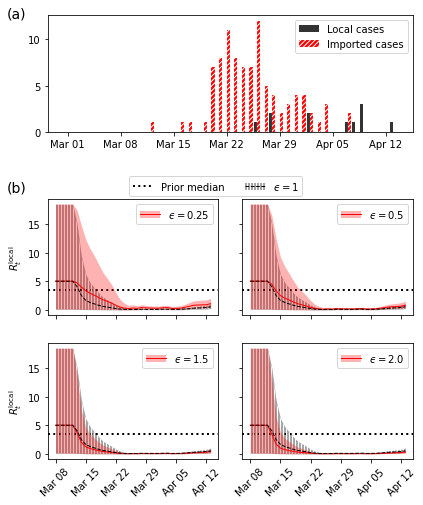

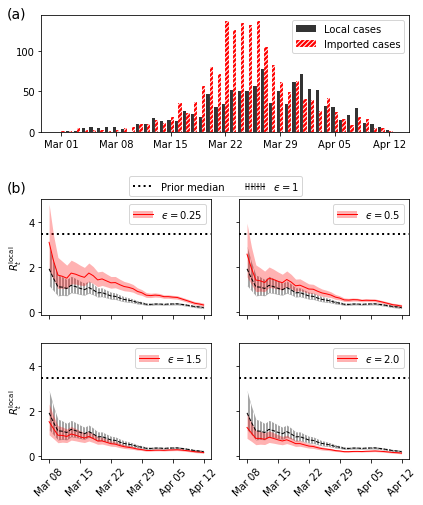

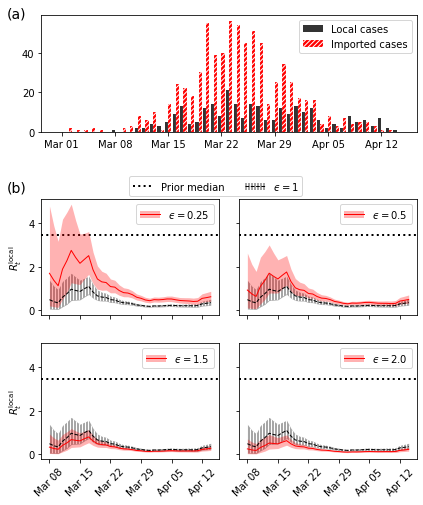

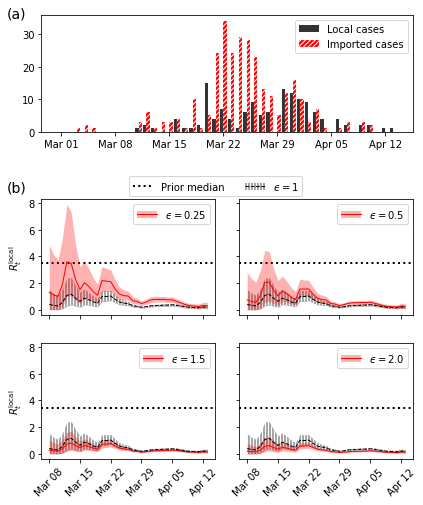

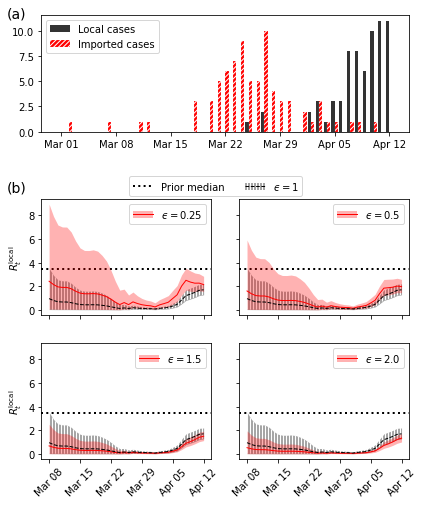

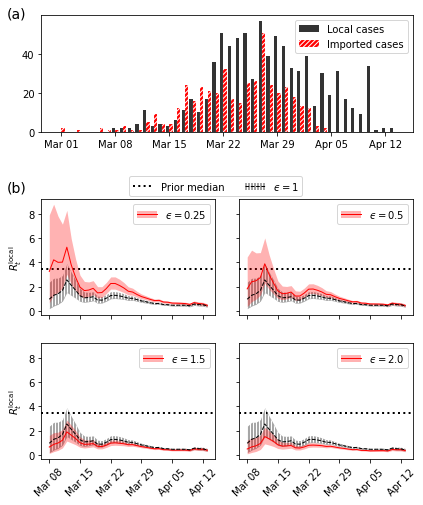

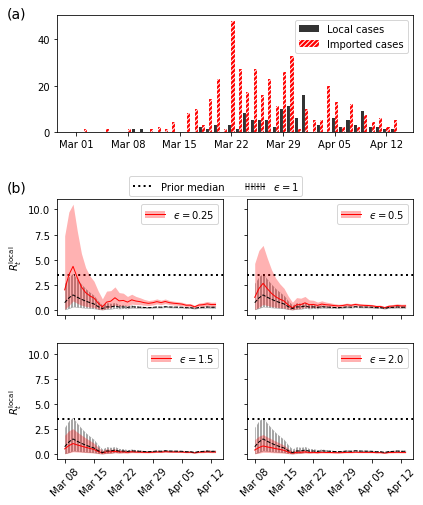

In [7]:
inference_times = sorted(list(set(all_intervals['Time Points'].tolist())))
epsilon_range = [0.25, 0.5, 1, 1.5, 2.0]


for region_num in range(len(regions)):
    all_intervals = regions_all_intervals[region_num]
    all_intervals = all_intervals[all_intervals['Central Probability']==0.95]
    
    inc_data = pd.DataFrame(
        {
            'Time': regions_start_times[region_num],
            'Incidence Number': regions_locally_infected_cases[region_num]
        }
    )

    imported_inc_data = pd.DataFrame(
        {
            'Time': regions_start_times[region_num],
            'Incidence Number': regions_imported_cases[region_num]
        }
    )
    
    fig = branchpro.figures.plot_r_inference(
        datetime.datetime(2020, 3, 1),
        regions_locally_infected_cases[region_num],
        regions_imported_cases[region_num],
        datetime.datetime(2020, 3, 1) + datetime.timedelta(days=inference_times[0]-1),
        list(epsilon_range),
        [all_intervals.loc[all_intervals['Epsilon']==eps] for eps in epsilon_range],
        prior_dist.median(),
        default_epsilon=1,
        show=False)
    
#     plt.savefig('{}_inference.pdf'.format(regions[region_num]))


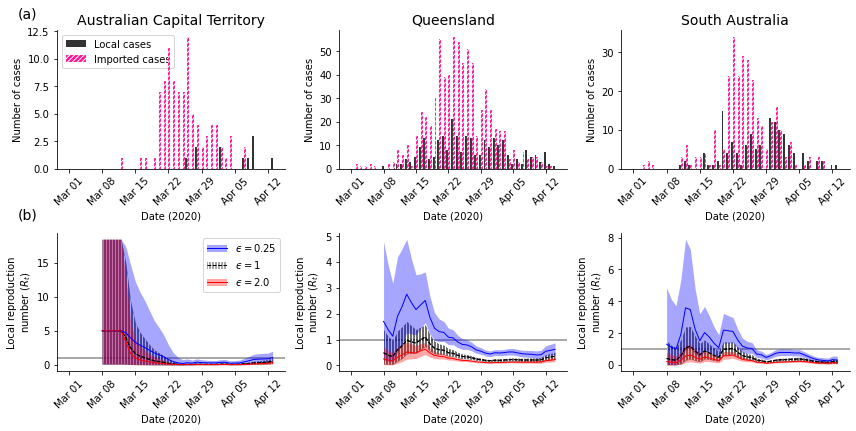

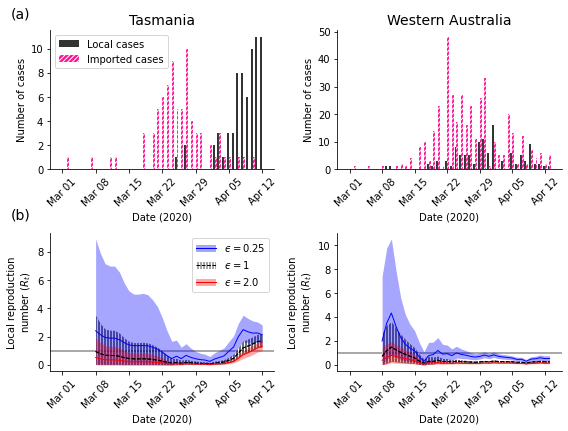

In [8]:
sparse_epsilon_range = [0.25, 1.0, 2.0]
regions_idx = [0, 2, 3]

region_results = []
for idx in regions_idx:
    all_intervals = regions_all_intervals[idx]
    all_intervals = all_intervals[all_intervals['Central Probability']==0.95]
    region_results.append([all_intervals.loc[all_intervals['Epsilon']==eps] for eps in sparse_epsilon_range])


fig = branchpro.figures.plot_regions_inference(
    datetime.datetime(2020, 3, 1),
    ['Australian Capital Territory', 'Queensland', 'South Australia'],
    [regions_locally_infected_cases[i] for i in regions_idx],
    [regions_imported_cases[i] for i in regions_idx],
    datetime.datetime(2020, 3, 1) + datetime.timedelta(days=inference_times[0]-1),
    list(sparse_epsilon_range),
    region_results,
    default_epsilon=1,
    show=False)

plt.savefig('../figures/Figure_S1_australia_inference.pdf')


regions_idx = [4, 6]

region_results = []
for idx in regions_idx:
    all_intervals = regions_all_intervals[idx]
    all_intervals = all_intervals[all_intervals['Central Probability']==0.95]
    region_results.append([all_intervals.loc[all_intervals['Epsilon']==eps] for eps in sparse_epsilon_range])


fig = branchpro.figures.plot_regions_inference(
    datetime.datetime(2020, 3, 1),
    ['Tasmania', 'Western Australia'],
    [regions_locally_infected_cases[i] for i in regions_idx],
    [regions_imported_cases[i] for i in regions_idx],
    datetime.datetime(2020, 3, 1) + datetime.timedelta(days=inference_times[0]-1),
    list(sparse_epsilon_range),
    region_results,
    default_epsilon=1,
    show=False)

plt.savefig('../figures/Figure_S2_australia_inference.pdf')